In [150]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

import sys
from contextlib import redirect_stdout

import matplotlib.pyplot as plt
import joblib

In [151]:
num_samples = 15000

In [152]:
if num_samples == 4000:
    num_data = str(num_samples)
else:
    num_data = ''

In [153]:
shuffled = '_shuffled'

In [154]:
# Read the data from the files
X_train_raw = pd.read_csv(f'dataset/X_train{num_data}{shuffled}.tsv', sep='\t')
X_test_raw = pd.read_csv(f'dataset/X_test{num_data}{shuffled}.tsv', sep='\t')
y_train = pd.read_csv(f'dataset/y_train{num_data}{shuffled}.tsv', sep='\t')
y_test = pd.read_csv(f'dataset/y_test{num_data}{shuffled}.tsv', sep='\t')

# Save the current standard output
original_stdout = sys.stdout

In [155]:
# Input size
input_size = X_train_raw.shape[1]
print(f'Input size: {input_size}')

Input size: 180


In [136]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
standarization = f'StandardScaler{num_data}{shuffled}'

# Save the scaler
joblib.dump(scaler, f'scalers/{standarization}.joblib')

['scalers/StandardScaler_shuffled.joblib']

In [144]:
# Apply min-max scaling
scaler = MinMaxScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
standarization = f'MinMaxScaler{num_data}{shuffled}'

# Save the scaler
joblib.dump(scaler, f'scalers/{standarization}.pkl')

['scalers/MinMaxScaler_shuffled.pkl']

In [156]:
print(y_train.shape)
# Change the shape of the y_train to a 1d array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print(y_train.shape)

(9617, 1)
(9617,)


In [162]:
# Transform the data to a np array
X_train = np.array(X_train_raw)
X_test = np.array(X_test_raw)
print(X_train.shape)
print(X_test.shape)
standarization = f'{shuffled}'

(9617, 180)
(2405, 180)


In [163]:
model_name = f'RF{num_data}_{standarization}'

with open(f'reports/{model_name}.txt', 'w') as f:
    with redirect_stdout(f):

        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        # Guarda el modelo
        joblib.dump(model, f'models/{model_name}.pkl')

        # Get the mean absolute error on the validation data
        y_pred = model.predict(X_test)
        MAE = metrics.mean_absolute_error(y_test , y_pred)
        MSE = metrics.mean_squared_error(y_test , y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        # Print the metrics with 4 decimal digits
        print('Model: ', model_name)
        print(f'MAE = {MAE:.4f}')
        print(f'MSE = {MSE:.4f}')
        print(f'R2 = {r2:.4f}')

# Restore the original standard output
sys.stdout = original_stdout

print("END OF THE CELL")

END OF THE CELL


In [30]:
model_name = f'RF{num_data}_{standarization}_GS'

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error']
}

with open(f'reports/{model_name}.txt', 'w') as f:
    with redirect_stdout(f):
        print('Model: ', model_name)
        modelo_rf = RandomForestRegressor()

        grid_search = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=7)
        grid_search.fit(X_train, y_train)

        print(f'Best parameters: {grid_search.best_params_}')
        print(f'Best estimator: {grid_search.best_estimator_}')

        # Save the model
        joblib.dump(grid_search, f'models/{model_name}.pkl')

        # Test the model
        y_pred = grid_search.predict(X_test)

        print('================================================')
        print('================================================')
        MAE = metrics.mean_absolute_error(y_test , y_pred)
        MSE = metrics.mean_squared_error(y_test , y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        print(f'MAE = {MAE:.4f}')
        print(f'MSE = {MSE:.4f}')
        print(f'R2 = {r2:.4f}')
        print('================================================')
        print('================================================')

# Restore the original standard output
sys.stdout = original_stdout

print("END OF THE CELL")

c:\Users\cgonz\tfgEnv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cgonz\tfgEnv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cgonz\tfgEnv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\cgonz\tfgEnv\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\cgonz\tfgEnv\Lib\site-packages\sklearn\util

END OF THE CELL


In [164]:
model_name = f'RF{num_data}_{standarization}_opt'

with open(f'reports/{model_name}.txt', 'w') as f:
    with redirect_stdout(f):

        model = RandomForestRegressor(criterion='squared_error', max_depth=20, max_features='sqrt', n_estimators=200)

        model.fit(X_train,y_train)

        # Guarda el modelo
        joblib.dump(model, f'models/{model_name}.pkl')

        # Get the mean absolute error on the validation data
        y_pred = model.predict(X_test)
        MAE = metrics.mean_absolute_error(y_test , y_pred)
        MSE = metrics.mean_squared_error(y_test , y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        # Print the metrics with 4 decimal digits
        print('Model: ', model_name)
        print(f'MAE = {MAE:.4f}')
        print(f'MSE = {MSE:.4f}')
        print(f'R2 = {r2:.4f}')

# Restore the original standard output
sys.stdout = original_stdout

print("END OF THE CELL")

END OF THE CELL


In [165]:
model_name = f'NN{num_data}_{standarization}'

with open(f'reports/{model_name}.txt', 'w', encoding="utf-8") as f:
    with redirect_stdout(f):

        model = Sequential([
            layers.Input(shape=(X_train.shape[1],)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear'),
        ])

        optimizer = Adam(learning_rate=0.001)

        # Compile the network :
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        #model.compile(loss='huber', optimizer='adam', metrics=['mae', 'mse'])


        # Print the model summary
        model.summary()

        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist.tail()

        # Save the model
        model.save(f'models/{model_name}.keras')

        # Test the model
        y_pred = model.predict(X_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'R2: {r2}')

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MAE]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],  label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [MSE]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

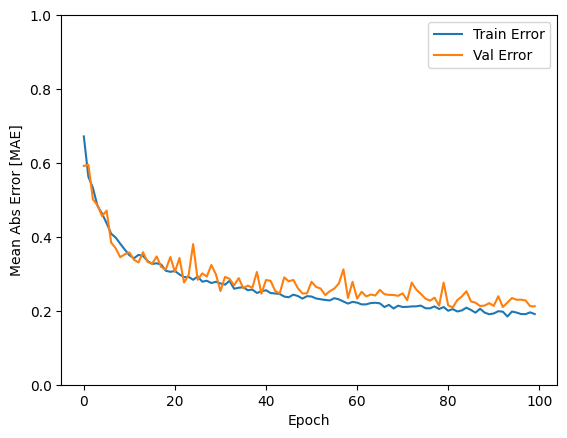

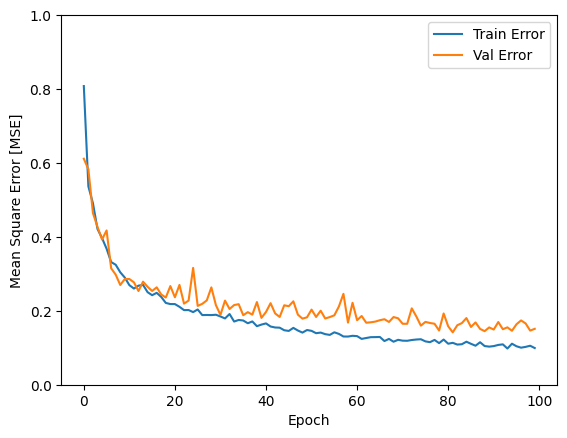

In [167]:
plot_history(history)

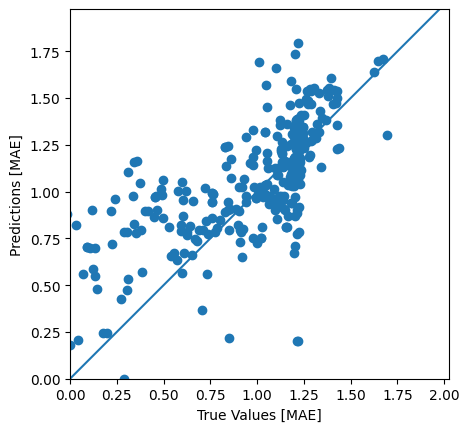

In [13]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])